In [1]:
#@title Importing required libraries, classes and functions
# Notebook display
from PIL import Image
from google.colab import files, drive
from os import listdir
from os.path import exists
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm_notebook

# PyTorch
import torch
from torch.optim import Adam
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import CocoDetection
from torch.hub import load_state_dict_from_url
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module, Sequential, Upsample, ReflectionPad2d, Conv2d, InstanceNorm2d, ReLU, MaxPool2d


In [2]:
custom_images_for_training = False #@param {type:'boolean'}
if custom_images_for_training:
    files.upload()

In [3]:
if not exists('/content/drive/MyDrive'): drive.mount('/content/drive/')

Mounted at /content/drive/


# Setting up the dataset

 Downloading the coco dataset

In [4]:
!wget http://images.cocodataset.org/annotations/image_info_test2017.zip
!wget http://images.cocodataset.org/zips/test2017.zip

--2023-10-09 05:53:35--  http://images.cocodataset.org/annotations/image_info_test2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.216.177, 52.216.250.204, 52.217.40.20, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.216.177|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1144034 (1.1M) [application/zip]
Saving to: ‘image_info_test2017.zip’

image_info_test2017 100%[===================>]   1.09M  2.96MB/s    in 0.4s    

2023-10-09 05:53:35 (2.96 MB/s) - ‘image_info_test2017.zip’ saved [1144034/1144034]

--2023-10-09 05:53:35--  http://images.cocodataset.org/zips/test2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.216.177, 52.216.250.204, 52.217.40.20, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.216.177|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6646970404 (6.2G) [application/zip]
Saving to: ‘test2017.zip’

test2017.zip  

 Extracting the dataset

In [5]:
import zipfile
import time
from os import listdir
zip_files = [i for i in listdir() if i.endswith('zip')]
for zfile in zip_files:
  zf = zipfile.ZipFile(zfile)
  for file in tqdm_notebook(zf.infolist(), desc=f"Extracting {zfile} "):
      zf.extract(file)

Extracting test2017.zip :   0%|          | 0/40671 [00:00<?, ?it/s]

Extracting image_info_test2017.zip :   0%|          | 0/2 [00:00<?, ?it/s]

Setting the path to extracted dataset

In [6]:
anot_path = "/content/annotations/image_info_test2017.json"
image_folder = "test2017"

Check for content and style image

In [7]:
def images_exists():
  both_exists = 0
  for f in listdir():
    if f.endswith('.jpg'):
      if f.startswith('content') or f.startswith('style'):
        both_exists += 1
  if both_exists>1:
    return True
  else:
    return False

if custom_images_for_training and not images_exists():
    raise Exception("Upload both content and style image")
else:
    !wget -O default_content.jpg https://upload.wikimedia.org/wikipedia/commons/2/25/Leonardo_DiCaprio_2014.jpg
    !wget -O default_style.jpg https://upload.wikimedia.org/wikipedia/commons/8/8e/Self-portrait_with_Felt_Hat_by_Vincent_van_Gogh.jpg

--2023-10-09 05:57:55--  https://upload.wikimedia.org/wikipedia/commons/2/25/Leonardo_DiCaprio_2014.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154564 (151K) [image/jpeg]
Saving to: ‘default_content.jpg’

default_content.jpg 100%[===================>] 150.94K  --.-KB/s    in 0.06s   

2023-10-09 05:57:56 (2.62 MB/s) - ‘default_content.jpg’ saved [154564/154564]

--2023-10-09 05:57:56--  https://upload.wikimedia.org/wikipedia/commons/8/8e/Self-portrait_with_Felt_Hat_by_Vincent_van_Gogh.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9491807 (9.1M) [image/jpeg]
Saving to: ‘default_style.jpg’

default_

# Defining Preprocessing, Postprocessing, Draw functions and Constants

In [8]:
# Image size
SIZE = 1280

# ImageNet statistics
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

# Determine device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pre-processing
def prep(image, size=SIZE, normalize=True, mean=MEAN, std=STD, device=DEVICE):
    resize = transforms.Compose([transforms.Resize(size, Image.LANCZOS),
                                 transforms.CenterCrop(size)])
    image = resize(image.convert('RGB'))
    if normalize:
        norm = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize(mean, std)])
        return norm(image).unsqueeze(0).to(device)
    else:
        return image

# Post-processing
def post(tensor, mean=MEAN, std=STD):
    mean, std = torch.tensor(mean).view(3, 1, 1), torch.tensor(std).view(3, 1, 1)
    tensor = transforms.Lambda(lambda x: x * std + mean)(tensor.cpu().clone().squeeze(0))
    return transforms.ToPILImage()(tensor.clamp_(0, 1))

# Draw content, style and output images
def draw(input, content_image, style_image):
    output = post(input)

    clear_output(wait=True)
    plt.figure(figsize=(18, 6))

    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(prep(content_image, normalize=False))
    ax1.axis('off')
    ax1.set_title('Content Image')

    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(prep(style_image, normalize=False))
    ax2.axis('off')
    ax2.set_title('Style Image')

    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(output)
    ax3.axis('off')
    ax3.set_title('Output Image')

    plt.show()
    return output

# Defining Transformation Network and other essential classes

In [9]:
class ConvBlock(Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, upsample=False, norm=True, relu=True):
        super().__init__()

        self.upsample = Upsample(scale_factor=2) if upsample else None
        self.conv_block = Sequential(ReflectionPad2d(kernel_size // 2), Conv2d(in_channels, out_channels, kernel_size, stride))
        self.norm = InstanceNorm2d(out_channels, affine=True) if norm else None
        self.relu = ReLU(inplace=True) if relu else None

    def forward(self, x):
        if self.upsample:
            x = self.upsample(x)
        conv = self.conv_block(x)
        if self.norm:
            conv = self.norm(conv)
        if self.relu:
            conv = self.relu(conv)
        return conv


class ResBlock(Module):
    def __init__(self, channels):
        super().__init__()

        self.conv_blocks = Sequential(ConvBlock(channels, channels, kernel_size=3),
                                      ConvBlock(channels, channels, kernel_size=3, relu=False))

    def forward(self, x):
        return self.conv_blocks(x) + x


class ImageTransformationNetwork(Module):
    def __init__(self, num_res_blocks=5):
        super().__init__()

        self.transnet = Sequential(ConvBlock(3, 32, kernel_size=9, stride=1),
                                   ConvBlock(32, 64, kernel_size=3, stride=2),
                                   ConvBlock(64, 128, kernel_size=3, stride=2),
                                   *[ResBlock(128) for i in range(num_res_blocks)],
                                   ConvBlock(128, 64, kernel_size=3, upsample=True),
                                   ConvBlock(64, 32, kernel_size=3, upsample=True),
                                   ConvBlock(32, 3, kernel_size=9, norm=False, relu=False))

    def forward(self, x):
        return self.transnet(x)

In [10]:
transnet = ImageTransformationNetwork().to(DEVICE)

def transfer_style(content_image, style_image, style_path):
    transnet.load_state_dict(torch.load(style_path))
    transnet.eval()
    with torch.no_grad():
        output = draw(transnet(prep(content_image)), content_image, style_image)
    return output

In [11]:
#@title Defining Content, Style loss classes
class ContentLoss(Module):
    def forward(self, features, targets):
        loss = F.mse_loss(features, targets)
        return loss


class StyleLoss(Module):
    def forward(self, features, GM_t):
        GM_f = self.gram_matrix(features)
        loss = F.mse_loss(GM_f, GM_t)
        return loss

    @staticmethod
    def gram_matrix(inputs):
        BS, C, H, W = inputs.size()
        inputs = inputs.view(BS, C, H * W)
        GM = inputs.bmm(inputs.transpose(1, 2))
        return GM.div_(C * H * W)

# Defining Feature Extractor and loading dataset for training

In [13]:
class VGG16(Module):
    def __init__(self):
        super().__init__()

        # Feature Extractor
        self.conv1_1 = Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 =   MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 =   MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 =   MaxPool2d(kernel_size=2, stride=2)

        self.conv4_1 = Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 =   MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 =   MaxPool2d(kernel_size=2, stride=2)

        # Freeze Parameters
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x, out_layers):
        out = dict()

        out['conv1_1'] = F.relu(self.conv1_1(x))
        out['conv1_2'] = F.relu(self.conv1_2(out['conv1_1']))
        out['pool1'] = self.pool1(out['conv1_2'])

        out['conv2_1'] = F.relu(self.conv2_1(out['pool1']))
        out['conv2_2'] = F.relu(self.conv2_2(out['conv2_1']))
        out['pool2'] = self.pool2(out['conv2_2'])

        out['conv3_1'] = F.relu(self.conv3_1(out['pool2']))
        out['conv3_2'] = F.relu(self.conv3_2(out['conv3_1']))
        out['conv3_3'] = F.relu(self.conv3_3(out['conv3_2']))
        out['pool3'] = self.pool3(out['conv3_3'])

        out['conv4_1'] = F.relu(self.conv4_1(out['pool3']))
        out['conv4_2'] = F.relu(self.conv4_2(out['conv4_1']))
        out['conv4_3'] = F.relu(self.conv4_3(out['conv4_2']))
        out['pool4'] = self.pool4(out['conv4_3'])

        out['conv5_1'] = F.relu(self.conv5_1(out['pool4']))
        out['conv5_2'] = F.relu(self.conv5_2(out['conv5_1']))
        out['conv5_3'] = F.relu(self.conv5_3(out['conv5_2']))
        out['pool5'] = self.pool5(out['conv5_3'])

        return [out[layer] for layer in out_layers]

In [14]:
content_loss_list = list()
style_loss_list = list()
total_loss_list = list()


In [15]:
def train(transnet, train_loader, style_targets, content_loss_fn,
          style_loss_fn, style_name, content_weight=1, style_weight=1e5,
          tv_weight=1e-6, epochs=2):
    num_batches = len(train_loader)
    optimizer = Adam(transnet.parameters(), lr=1e-3)

    for epoch in trange(epochs, desc='Epochs'):
        batches = iter(train_loader)
        for batch_idx in tqdm_notebook(range(1, num_batches + 1), desc='Batches', leave=False):
            batch = next(batches).to(DEVICE)
            images_in_batch = len(batch)

            optimizer.zero_grad()
            vgg16_out = vgg16(batch, content_layers)
            transnet_out = transnet(batch)
            vgg16_transnet_out = vgg16(transnet_out, style_layers)

            # Content Loss
            content_preds, content_targets = vgg16_transnet_out[1], vgg16_out[0]
            content_loss = content_weight * content_loss_fn(content_preds, content_targets)
            content_loss_list.append(content_loss)
            # Style Loss
            style_loss = 0
            for i in range(num_style_layers):
                style_loss += style_loss_fn(vgg16_transnet_out[i], style_targets[i][:images_in_batch])
            style_loss_list.append(style_loss)
            style_loss *= style_weight

            # Total Variation Regularization
            diff_i = ((transnet_out[:, :, :, 1:] - transnet_out[:, :, :, :-1]).abs()).sum()
            diff_j = ((transnet_out[:, :, 1:, :] - transnet_out[:, :, :-1, :]).abs()).sum()
            tv_reg = tv_weight * (diff_i + diff_j)

            total_loss_list.append(style_loss + content_loss)

            total_loss = style_loss + content_loss + tv_reg

            total_loss.backward()
            optimizer.step()

    # Save the trained weights
    torch.save(transnet.state_dict(), f'{style_name}.pth')

In [16]:
vgg16 = VGG16().to(DEVICE)


state = vgg16.state_dict()
pretrained_vgg16 = 'https://download.pytorch.org/models/vgg16-397923af.pth'
new_state_values = list(load_state_dict_from_url(pretrained_vgg16).values())

for i, key in enumerate(state):
    state[key] = new_state_values[i]

vgg16.load_state_dict(state)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 211MB/s]


<All keys matched successfully>

In [17]:

image2tensor = transforms.Compose([transforms.Resize(256, Image.LANCZOS),
                                   transforms.CenterCrop(256),
                                   transforms.ToTensor(),
                                   transforms.Normalize(MEAN, STD)])

train_dataset = CocoDetection(image_folder, anot_path, image2tensor)
train_loader = DataLoader(train_dataset, batch_size=4, collate_fn=lambda batch: torch.stack([x[0] for x in batch]))
clear_output()

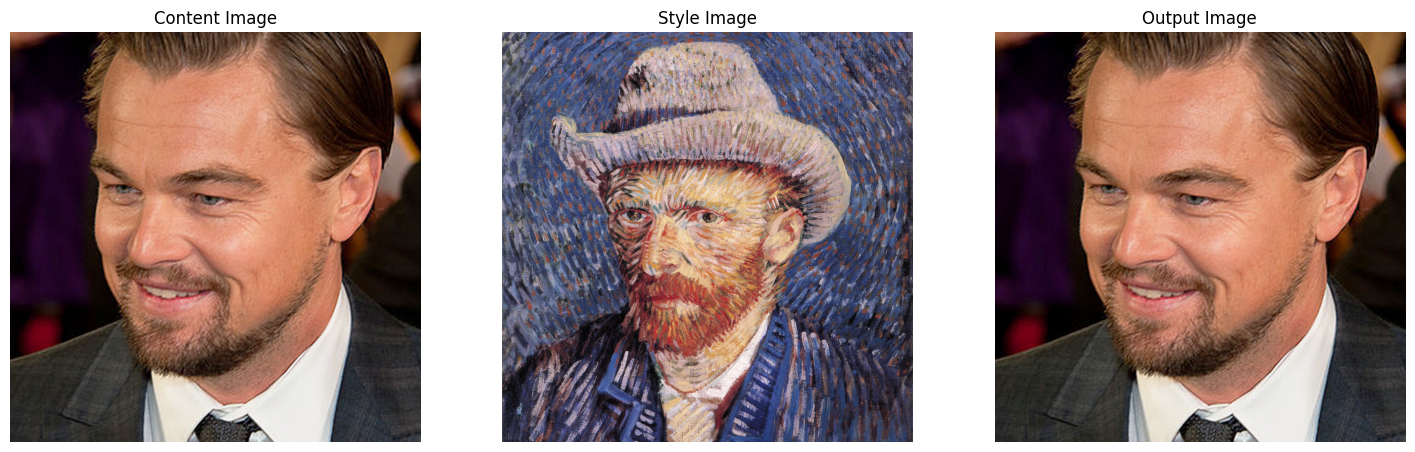

In [18]:

# Open and prepare images
if custom_images_for_training:
  content_image, style_image = Image.open('content.jpg'), Image.open('style.jpg')
  content, style = prep(content_image), prep(style_image)
else:
  content_image, style_image = Image.open('default_content.jpg'), Image.open('default_style.jpg')
  content, style = prep(content_image), prep(style_image)

# Display images
_ = draw(content, content_image, style_image)

In [19]:
# Layers of content/style reconstruction
content_layers = ['conv2_2','conv4_2']
style_layers = ['conv1_2', 'conv2_2', 'conv3_3', 'conv4_3']
num_style_layers = len(style_layers)

# Style targets
style_tensors = style.repeat(4, 1, 1, 1)
style_targets = [StyleLoss.gram_matrix(target) for target in vgg16(style_tensors, style_layers)]

# Loss functions
content_loss_fn = ContentLoss()
style_loss_fn = StyleLoss()

# Testing

In [ ]:
#@title Train For A Style
style_name = "van_gogh_portrait" #@param {type:"string"}
content_weight = 1 #@param {type:'slider',max:10,min:1,step:1}
style_weight = 2 #@param {type:'slider',max:10,min:1,step:1}
epoch = 1 #@param {type:'slider',max:5,min:1,step:1}
style_weight = 10**style_weight
content_weight = 10**content_weight

train(transnet, train_loader, style_targets, content_loss_fn,
      style_loss_fn, style_name,content_weight=content_weight,
      style_weight=style_weight, epochs=epoch)

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/10168 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
if custom_images_for_training:
 ! cp /content/{style_name}.pth /content/drive/MyDrive/style_gen
 ! cp /content/style.jpg /content/drive/MyDrive/style_gen/{style_name}.jpg

In [ ]:
#@title Apply a Style
from ipywidgets import interact
# files.upload_file('content.jpg')
def apply_style(style):
  return transfer_style(Image.open('default_content.jpg'),
                 Image.open(f"/content/drive/MyDrive/style_gen/{style.replace('pth','jpg')}"),
                 f"/content/drive/MyDrive/style_gen/{style}")

if exists('/content/drive/MyDrive/style_gen'):
  styles = [i for i in listdir('/content/drive/MyDrive/style_gen') if i.endswith('pth')]
else:
  print('No Style found.')

interact(apply_style, style=styles)

Output hidden; open in https://colab.research.google.com to view.